# Section 1: QKeras

In [16]:
# Switching for colab
%tensorflow_version 1.x

In [17]:
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax

from qkeras import QDense, QActivation, binary, quantized_bits

import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    B_train = x_train.shape[0]
    B_test = x_test.shape[0]

    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))

    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    y_train = y_train + np.random.uniform(0.0, 0.02, y_train.shape)
    y_train = y_train / np.sum(y_train, axis=1, keepdims=True)
    
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    return x_train, y_train, x_test, y_test

In [6]:
def get_model(verbose=True):
    x = x_i = Input((784,), name="input")
    x = Dense(300, name="d1")(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(100, name="d2")(x)
    x = Activation("relu", name="relu2")(x)
    x = Dense(10, name="d3")(x)
    x = Activation("softmax", name="softmax")(x)
    
    model = Model(inputs=x_i, outputs=x)

    if verbose:
        model.summary();
    
    return model

In [8]:
def get_model_q(alphas, verbose=True):
    x = x_i = Input((784,), name="input")
    x = QDense(300, name="d1",
               kernel_quantizer=binary(alpha=alphas.pop(0)),
               bias_quantizer=quantized_bits(4,2,1))(x)
    x = QActivation("binary()", name="act1")(x)
    x = QDense(100, name="d2",
               kernel_quantizer=binary(alpha=alphas.pop(0)),
               bias_quantizer=quantized_bits(4,2,1))(x)
    x = QActivation("binary()", name="act2")(x)
    x = QDense(10, name="d3",
               kernel_quantizer=binary(alpha=alphas.pop(0)),
               bias_quantizer=quantized_bits(4,2,1))(x)
    x = Activation("softmax", name="softmax")(x)
    
    model = Model(inputs=x_i, outputs=x)

    if verbose:
        model.summary();
    
    return model

In [9]:
def train(data, verbose=True):
    x_train, y_train, x_test, y_test = data
    weight_file_name = "elen521-lab6.hdf5"
    model = get_model(verbose=verbose)
    optimizer = Adam(0.01)

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
    
    if os.path.exists(weight_file_name):
        model.load_weights(weight_file_name)
    else:
        history = model.fit(
            x_train, y_train,
            batch_size=64,
            epochs=5,
            validation_split=0.05,
            verbose=True,
            shuffle=True)
        model.save_weights(weight_file_name)
    
    eval_res = model.evaluate(x_test, y_test)
    if verbose:
        print(eval_res)
    
    return eval_res, model

In [10]:
def get_alpha(model):
    layers_with_weights = ["d1", "d2", "d3"]
    alphas = []

    for layer in model.layers:
        if layer.name in layers_with_weights:
            weight_and_bias = layer.get_weights()
            weight = weight_and_bias[0]
            alphas.append(np.mean(np.abs(weight)))

    return alphas

In [11]:
def train_q(data, alphas, verbose=True):
    x_train, y_train, x_test, y_test = data
    model = get_model_q(alphas, verbose=verbose)
    optimizer = Adamax(0.02, beta_1=0.9, beta_2=0.999)

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

    history = model.fit(
        x_train, y_train,
        batch_size=64,
        epochs=5,
        validation_split=0.05,
        verbose=True,
        shuffle=True)
    
    eval_res = model.evaluate(x_test, y_test)
    if verbose:
        print(eval_res)
    
    return eval_res, model


In [12]:
def main():
    data = load_data()
    eval_res, model = train(data)
    
    alphas = get_alpha(model)
    eval_res_q = train_q(data, alphas)

In [13]:
main()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
d1 (Dense)                   (None, 300)               235500    
_________________________________________________________________
relu1 (Activation)           (None, 300)               0         
_________________________________________________________________
d2 (Dense)                   (None, 100)               30100     
_________________________________________________________________
relu2 (Activation)           (None, 100)               0         
_________________________________________________________________
d3 (Dense)                   (None, 10)                1010      
______________________________________________

# Section 2 + 3: Neural Style Transfer

In [16]:
# Switching for colab
%tensorflow_version 2.x

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from scipy.optimize import fmin_l_bfgs_b

In [82]:
content_path = 'images/1.jpg'
style_path = 'styles/11.jpg'

### Visualize the images

In [83]:
def plot_src_images(content_path, style_path):
    content_img = load_img(content_path)
    style_img   = load_img(style_path)
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.02, wspace=0.01,
                    left=0, right=1, bottom=0, top=1)

    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])        
    ax.imshow(content_img)
    ax.set_title("Content Image")

    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) 
    ax.imshow(style_img)
    ax.set_title("Style Image")
    plt.show()

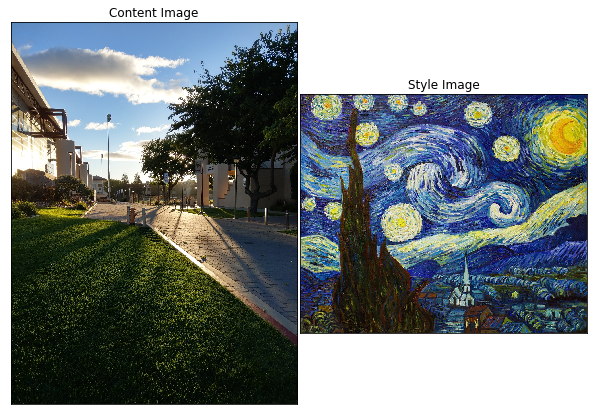

In [84]:
plot_src_images(content_path, style_path)

### Preparation

Global Variables

In [5]:
RESULT_DIR = "results"

In [6]:
content_img = load_img(content_path)
width, height = content_img.size

img_nrows = width # or hardcode here
img_nrows = 800
img_ncols = height if width == img_nrows else \
    int(height / width * img_nrows)

print("size: %d x %d" % (img_nrows, img_ncols))

size: 800 x 1066


In [7]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

n_content_layers = len(content_layers)
n_style_layers = len(style_layers)

Utilities

In [8]:
def preprocess_and_load_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = applications.vgg19.preprocess_input(img)
    return img

In [9]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
        
    # Remove zero-center by mean pixel, which is from ImageNet
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
get_filename_from_path = lambda path: os.path.split(content_path)[-1].split(".")[0]

In [11]:
def pngs_to_gif(image_names):
    assert(len(image_names) > 0)
    
    single_img_filename = get_filename_from_path(image_names[0])
    gif_filename = os.path.join(RESULT_DIR, "%s.gif" % single_img_filename)
    
    images = []
    for img_name in image_names:
        images.append(imageio.imread(img_name))
    imageio.mimsave(gif_filename, images)
    
    print("Done")

    return gif_filename

### Loss functions

In [12]:
def get_content_loss(content, combination):
    return tf.reduce_mean(tf.square(content - combination))

In [13]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [14]:
def get_total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Model and feature definition

In [15]:
def get_model():
    # build the VGG19 network with our 3 images as input
    # the model will be loaded with pre-trained ImageNet weights
    model = applications.vgg19.VGG19(weights='imagenet', include_top=False)
    model.trainable = False
    print('Model loaded.')
    
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    # Get the style and content feature representations from our model  
    style_outputs   = [outputs_dict[layer_name] for layer_name in style_layers]
    content_outputs = [outputs_dict[layer_name] for layer_name in content_layers]
    
    model_outputs = style_outputs + content_outputs

    return Model(model.input, model_outputs)

In [16]:
def get_feature_representations(model, content_path, style_path):
    # Load images in 
    content_image = preprocess_and_load_image(content_path)
    style_image   = preprocess_and_load_image(style_path)
  
    # Batch compute content and style features
    style_outputs   = model(style_image)
    content_outputs = model(content_image)
  
    # Get the style and content feature representations from our model  
    style_features   = [style_layer[0] for style_layer in style_outputs[:n_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[n_style_layers:]]
    return style_features, content_features

### Computing the loss and gradients

In [17]:
def compute_loss(model, weights, features, combination_img):
    content_weight, style_weight, total_variation_weight = weights
    style_features, content_features = features
  
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(combination_img)
    
    style_output_features   = model_outputs[:n_style_layers]
    content_output_features = model_outputs[n_style_layers:]
  
    style_loss   = 0
    content_loss = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(n_style_layers)
    for target_style, comb_style in zip(style_features, style_output_features):
        style_loss += weight_per_style_layer * get_style_loss(target_style, comb_style[0])
    
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(n_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_loss += weight_per_content_layer * get_content_loss(target_content, comb_content[0])
  
    loss = total_variation_weight * get_total_variation_loss(combination_img)

    style_loss   *= style_weight
    content_loss *= content_weight

    # Get total loss
    loss += style_loss + content_loss 
    return loss

In [18]:
def compute_grads_and_loss(args):
    with tf.GradientTape() as tape: 
        loss = compute_loss(**args)
    return tape.gradient(loss, args['combination_img']), loss

### Training

In [19]:
# Show result in Jupyter Notebook
import IPython.display

In [29]:
def apply_style_transfer(content_path, style_path,
                         iterations=100,
                         content_weight=1.0,
                         style_weight=5e-2,
                         total_variation_weight=1.0,
                         save_best=True,
                         save_gif=True):
    
    image_filename = get_filename_from_path(content_path)
    result_prefix  = os.path.join(RESULT_DIR, image_filename)
    
    model = get_model()
    
    # The tunnable parameters to control the result
    weights  = (content_weight, style_weight, total_variation_weight)

    # The generated output from style image and content image
    features = get_feature_representations(model, content_path, style_path)
    
    # Optimizer
    opt = Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    # Image to store result
    combination_img = preprocess_and_load_image(content_path)
    combination_img = tf.Variable(combination_img, dtype=tf.float32)
    
    # Arguments for computing grads and loss
    args = {
      'model': model,
      'weights': weights,
      'combination_img': combination_img,
      'features': features,
    }

    # Store our best result
    best_loss, best_img = float('inf'), None
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means 
    
    # For displaying
    display_num_rows  = 2
    display_num_cols  = 5
    display_interval  = iterations // (display_num_rows * display_num_cols)
    global_start_time = time.time()
    
    imgs = []
    for i in range(iterations):
        print('== Iteration: %d' % (i + 1))
        start_time = time.time()
        
        grads, loss = compute_grads_and_loss(args)
        opt.apply_gradients([(grads, combination_img)])
        clipped = tf.clip_by_value(combination_img, min_vals, max_vals)
        combination_img.assign(clipped)

        print('Current loss:', loss)

        # Save current generated image
        img = deprocess_img(combination_img.numpy().copy())
        fname = result_prefix + '_at_iteration_%d.png' % (i + 1)
        imgs.append({"name": fname, "image": img})
        save_img(fname, img)

        # Update best loss and best image from total loss. 
        if loss < best_loss:
            best_loss = loss
            best_img  = img

        end_time = time.time()
        print('Image saved as', fname)
        print('Iteration %d completed in %ds' % ((i + 1), end_time - start_time))

        if i % display_interval == 0:
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(img))
            
        
    print('Total time: {:.4f}s'.format(time.time() - global_start_time))

    # Save all pngs as a gif
    if save_gif:
        img_names = list(map(lambda x: x["name"], imgs))
        pngs_to_gif(img_names)
        
    # Randomly display 10 historical images
    IPython.display.clear_output(wait=True)
    IPython.display.display_png(Image.fromarray(best_img))
    img_samples = sorted(np.random.choice(
        imgs, display_num_rows * display_num_cols, replace=False),
                        key=lambda x: x["name"])
    plt.figure(figsize=(14, 4))
    for i, img in enumerate(img_samples):
        plt.subplot(display_num_rows, display_num_cols, i + 1)
        plt.imshow(img["image"])
        plt.xticks([])
        plt.yticks([])

    if save_best:
        fname = "%s_best.png" % result_prefix
        save_img(fname, best_img)
    else:
        return best_img, best_loss

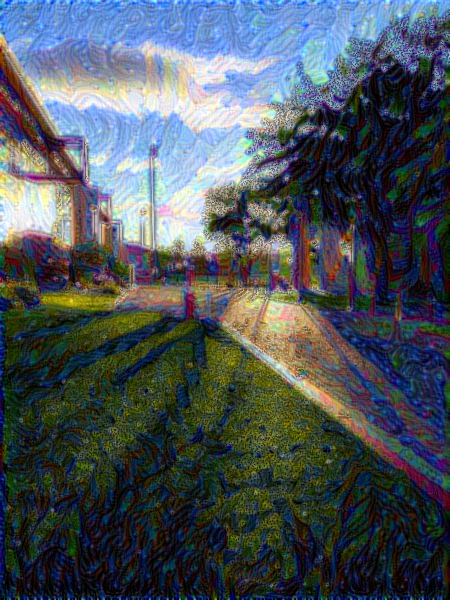

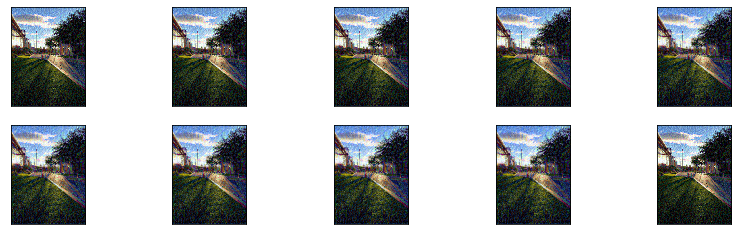

In [86]:
apply_style_transfer(content_path, style_path, content_weight=5, iterations=27)

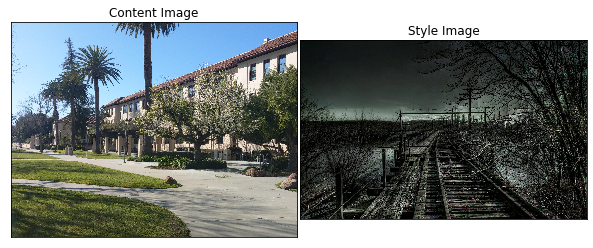

In [110]:
plot_src_images('images/7.jpg', 'styles/7.jpg')

In [60]:
content_img = load_img('images/7.jpg')
width, height = content_img.size

img_nrows = width # or hardcode here
img_nrows = 600
img_ncols = height if width == img_nrows else \
    int(height / width * img_nrows)

print("size: %d x %d" % (img_nrows, img_ncols))

size: 600 x 450


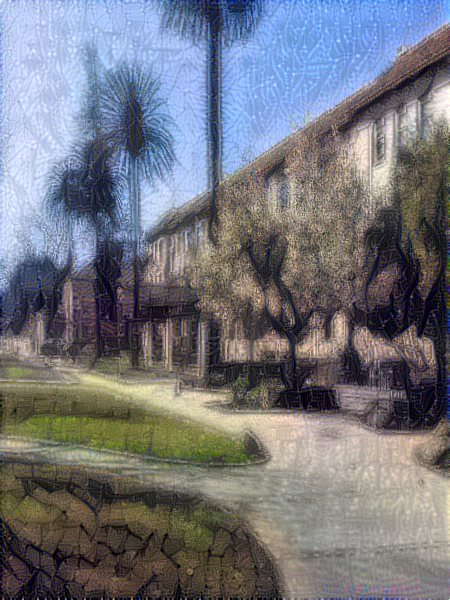

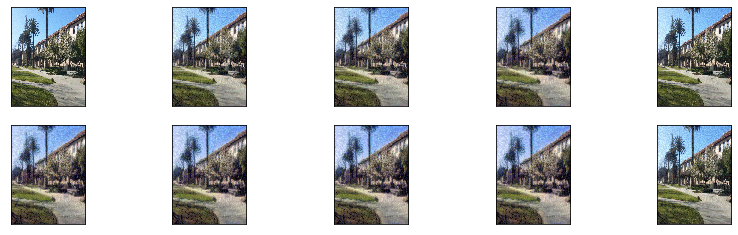

In [111]:
apply_style_transfer('images/7.jpg', 'styles/7.jpg', content_weight=2, style_weight=8e-2, iterations=40)

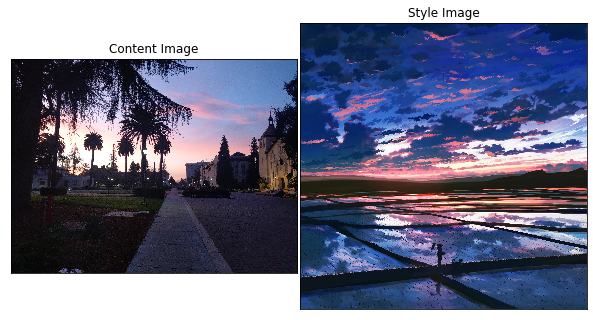

In [30]:
plot_src_images('images/5.jpg', 'styles/6.jpg')

In [31]:
content_img = load_img('images/5.jpg')
width, height = content_img.size

img_nrows = 600
img_ncols = height if width == img_nrows else \
    int(height / width * img_nrows)

print("size: %d x %d" % (img_nrows, img_ncols))

size: 600 x 450


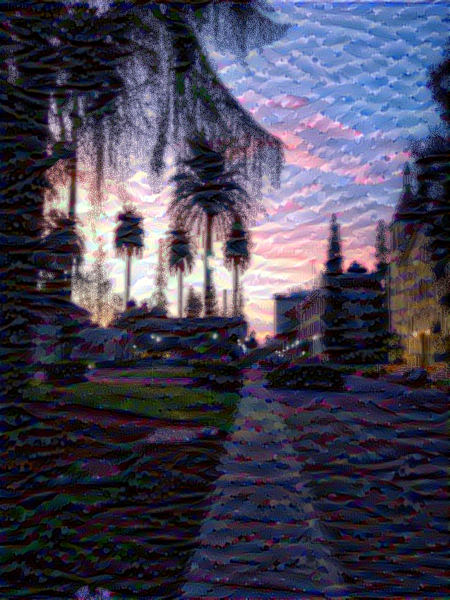

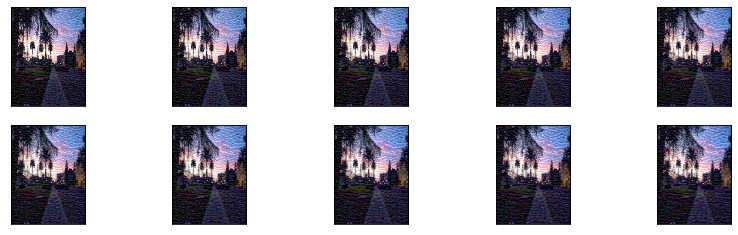

In [92]:
apply_style_transfer('images/5.jpg', 'styles/6.jpg', content_weight=10, style_weight=4e-2, iterations=32)

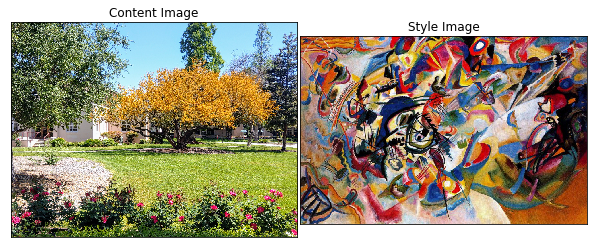

In [87]:
plot_src_images('images/2.jpg', 'styles/10.jpg')

In [55]:
content_img = load_img('images/2.jpg')
width, height = content_img.size

img_nrows = 600
img_ncols = height if width == img_nrows else \
    int(height / width * img_nrows)

print("size: %d x %d" % (img_nrows, img_ncols))

size: 600 x 450


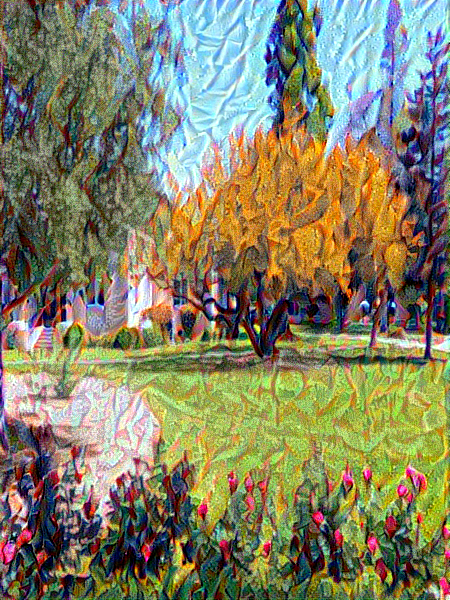

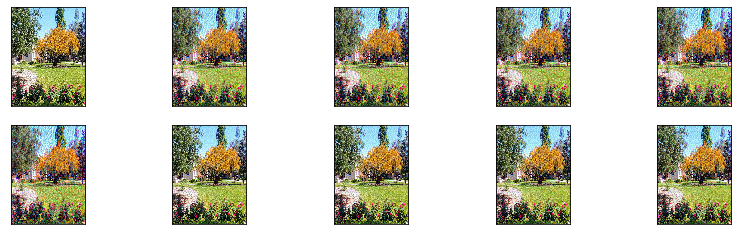

In [90]:
apply_style_transfer('images/2.jpg', 'styles/10.jpg', content_weight=10, style_weight=5e-1, iterations=24)

## Section 3: YOLO

In [1]:
import os
import sys

In [12]:
# Install `darkflow` as a gitsubmodule in the current directory,
# so we can upgrade the broken dependencies and use the local version.

CURR_DIR = os.getcwd()
DARKFLOW_DIR = os.path.join(CURR_DIR, "darkflow")

if DARKFLOW_DIR not in sys.path:
    sys.path.append(DARKFLOW_DIR)

In [43]:
import numpy as np
import time
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from darkflow.net.build import TFNet
import pafy
%matplotlib inline

### Global Variables

In [ ]:
VIDEO_PATH = "yolo_video.mp4"
OUTPUT_VIDEO_PATH = "yolo_video_processed.avi"

In [16]:
options = {
    'config': os.path.join(DARKFLOW_DIR, "cfg"),
    'model': os.path.join(DARKFLOW_DIR, "cfg", "yolo.cfg"),
    'load': os.path.join(DARKFLOW_DIR, "bin", "yolov2.weights"),
    'threshold': 0.7
}
tfnet = TFNet(options)

Parsing /Users/daniel/WatchAndLearn/ELEN521/Lab6/darkflow/cfg/yolo.cfg
Loading /Users/daniel/WatchAndLearn/ELEN521/Lab6/darkflow/bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 1.4426469802856445s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load 

In [ ]:
def create_yolo_video(tfnet, video_in_path=VIDEO_PATH, video_out_path=OUTPUT_VIDEO_PATH):
    cap    = cv2.VideoCapture(VIDEO_PATH)
    out    = cv2.VideoWriter(OUTPUT_VIDEO_PATH, -1, 20.0, (640,480))
    colors = [tuple(255 * np.random.rand(3)) for i in range(5)]

    while(cap.isOpened()):
        stime          = time.time()
        succeed, frame = cap.read()
        results        = tfnet.return_predict(frame)

        counter = 0
        if succeed:
            for color, result in zip(colors, results):
                tl = (result['topleft']['x'], result['topleft']['y'])
                br = (result['bottomright']['x'], result['bottomright']['y'])
                label = result['label']
                frame = cv2.rectangle(frame, tl, br, color, 7)
                frame = cv2.putText(frame, label, tl, cv2.FONT_HERSHEY_TRIPLEX, 1, (0,0,0), 2)

            # write the flipped frame
            frame = cv2.flip(frame, 0)

            out.write(frame)

            counter +=1

            if counter > 100:
                break

            print('FPS {:1f}'.format(1 / (time.time() - stime)))
            
            if cv2.waitKey(1)  & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    out.release()
    print('Done')

In [ ]:
url = "https://www.youtube.com/watch?v=T0jM37coZPo"
vPafy = pafy.new(url)
play = vPafy.getbest(preftype="webm")

create_yolo_video(tfnet, play.url)